# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine whether a customer will respond to an offer. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. Informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity.

Transactional data is given showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Users can make purchases on the app without having received or seen an offer.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



In [154]:
# Installation of useful libraries

!pip install seaborn
!pip install shap

In [147]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import json
import sklearn
from sklearn.model_selection import train_test_split
import boto3
import os
import sagemaker
from sagemaker.model import Model
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import matplotlib.pyplot as plt
from sagemaker.xgboost import XGBoostModel
import tarfile
import shap




In [56]:
region = sagemaker.Session().boto_region_name
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()
smclient = boto3.client('sagemaker')

In [57]:
# read in the json files
portfolio = pd.read_json('starbucks_data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('starbucks_data/profile.json', orient='records', lines=True)
transcript = pd.read_json('starbucks_data/transcript.json', orient='records', lines=True)

# Data Exploration and Preprocessing

I want to build customer response prediction models where given a customer and his demographical and transactional information, I can predict whether the customer will respond to a specific offer if he receives it. The data preprocessing steps are done below

In [58]:
# Viewing the portfolio dataset


portfolio

reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   
5       3  [web, email, mobile, social]           7         7       discount   
6       2  [web, email, mobile, social]          10        10       discount   
7       0       [email, mobile, social]           0         3  informational   
8       5  [web, email, mobile, social]           5         5           bogo   
9       2          [web, email, mobile]          10         7       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7  
5  2298d6c36e964ae4a3e7e9706d1fb8c2  
6  fafdcd668e3743c1bb461111dcafc2a4  
7  5a8bc65990b245e5a138643cd4eb9837  
8  f19421c1d4aa40978ebb69ca19b0e20d  
9  2906b810c7d4411798c6938adc9daaa5

In [59]:
# Viewing the first five rows of the profile dataset

profile.head()

gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN

In [60]:
# Viewing brief information of the features of the profile dataset

profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [61]:
# Viewing the first five rows of the transcript dataset

transcript.head()

person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0

In [62]:
# Viewing brief information of the features of the transcript dataset

transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


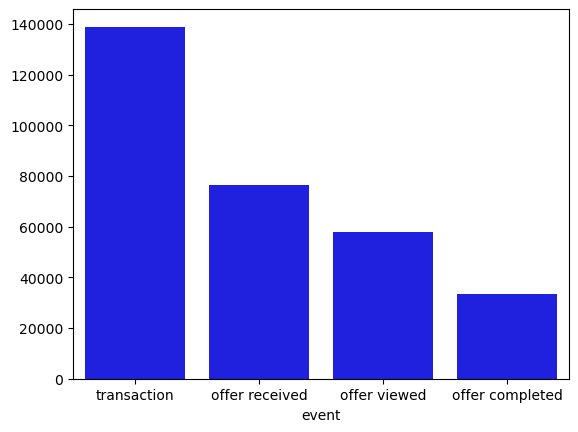

In [63]:
# Bar plot of the count of each category of the `event` feature in the `transcript` dataset

transcript_event =transcript['event'].value_counts()
sns.barplot(x=transcript_event.index, y=transcript_event.values, color='blue');

In the following cells, I would like to check if there was any instance of "informational offers" being completed. If not

In [64]:
# Creation of a separate dataset from the `transcript` dataset that shows only `offer completed` transactions

transcript_offer_comp = transcript[transcript['event'] == "offer completed"].drop(columns=['event'])
transcript_offer_comp.tail()

person  \
306475  0c027f5f34dd4b9eba0a25785c611273   
306497  a6f84f4e976f44508c358cc9aba6d2b3   
306506  b895c57e8cd047a8872ce02aa54759d6   
306509  8431c16f8e1d440880db371a68f82dd0   
306527  24f56b5e1849462093931b164eb803b5   

                                                    value  time  
306475  {'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...   714  
306497  {'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...   714  
306506  {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...   714  
306509  {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...   714  
306527  {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...   714

In [65]:
# Checking if any `offer completed` transaction was an informational offer

informational_id = ["3f207df678b143eea3cee63160fa8bed", "5a8bc65990b245e5a138643cd4eb9837"]
for value in transcript_offer_comp["value"]:
    if value["offer_id"] in informational_id:
        print("Completed informational offer found")
        break

In [66]:
# Removing all incomplete customer information

profile_cleaned_v1 = profile[profile['gender'].notnull()]
profile_cleaned_v1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               14825 non-null  int64  
 2   id                14825 non-null  object 
 3   became_member_on  14825 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


In [67]:
# Creation of a profile dataset for all incomplete profiles

profile_not_cleaned = profile[profile['gender'].isnull()]

In [68]:
# Creation of a list where the its contents are the ids of customers with incomplete profiles

incomplete_id = profile_not_cleaned["id"].tolist()

In [69]:
# Using the list created above to remove all transactions from personnel with incomplete demographic information

transcript_cleaned_v1 = transcript[~transcript["person"].isin(incomplete_id)]

In [70]:
# Brief informational view of the `cleaned` transcript dataset

transcript_cleaned_v1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 272762 entries, 0 to 306532
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  272762 non-null  object
 1   event   272762 non-null  object
 2   value   272762 non-null  object
 3   time    272762 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 10.4+ MB


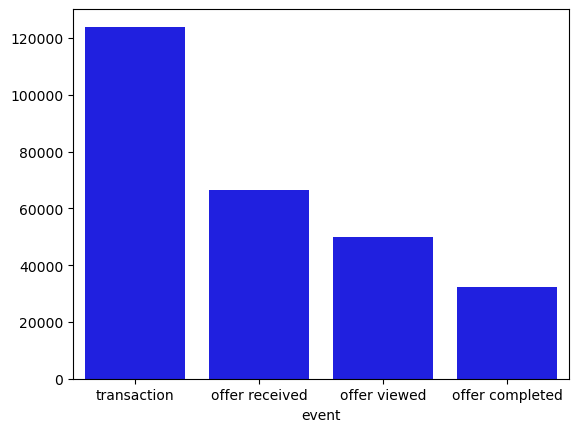

In [71]:
# Bar plot of the count of each category of the `event` feature in the ` cleaned transcript` dataset

transcript_event =transcript_cleaned_v1['event'].value_counts()
sns.barplot(x=transcript_event.index, y=transcript_event.values, color='blue');

In [72]:
# Remove all persons that didn't view an offer from the transcript dataset
grouped = transcript_cleaned_v1.groupby(['person', 'event']).size().unstack(fill_value=0)

# Initialize the list to keep track of persons to be removed
persons_to_be_removed = []

# Get the list of all persons from the profile data
list_of_persons = profile_cleaned_v1["id"].tolist()

# Loop through the list of persons
for person in list_of_persons:
    # Check if the person has "offer viewed" in their event history
    if grouped.get('offer viewed', {}).get(person, 0) == 0:
        # If they have not viewed an offer, add them to the removal list
        persons_to_be_removed.append(person)



In [73]:
transcript_cleaned_v2 = transcript_cleaned_v1[~transcript_cleaned_v1["person"].isin(persons_to_be_removed)]

In [74]:
# Viewing brief summary of the `edited` transcript dataset

transcript_cleaned_v2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 271606 entries, 0 to 306532
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  271606 non-null  object
 1   event   271606 non-null  object
 2   value   271606 non-null  object
 3   time    271606 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 10.4+ MB


In [75]:
transcript_cleaned_v2.head()

person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
5  389bc3fa690240e798340f5a15918d5c  offer received   
7  2eeac8d8feae4a8cad5a6af0499a211d  offer received   
8  aa4862eba776480b8bb9c68455b8c2e1  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
5  {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}     0  
7  {'offer id': '3f207df678b143eea3cee63160fa8bed'}     0  
8  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0

In [76]:
# Editing the transcript dataset in such a way that the customer ids will serve as the indices

transcript_cleaned_v3 = transcript_cleaned_v2.set_index("person").sort_index()


In [77]:
# Group the dataset using "person" and sort using "time" event

transcript_cleaned_v5 = transcript_cleaned_v3.groupby("person").apply(lambda x: x.sort_values(by="time")).reset_index(level=0, drop=True)

In [78]:
# Removing all informational offers

inf_offers = [{'offer id': '3f207df678b143eea3cee63160fa8bed'}, {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}]
transcript_cleaned_v6 = transcript_cleaned_v5[~transcript_cleaned_v5["value"].isin(inf_offers)]

In [79]:
# Removing all "transaction" events

event_to_remove = ["transaction"]
transcript_cleaned_v6 = transcript_cleaned_v6[~transcript_cleaned_v6["event"].isin(event_to_remove)]

In [80]:
# Replace the offer id dictionary with the actual id


def extract_offer_id(value):
    # Ensure the value is treated as a string and properly formatted
    if isinstance(value, dict):
        value = str(value)
    value_dict = json.loads(value.replace("'", '"').replace("offer id", "offer_id"))
    return value_dict['offer_id']



# Normalize and extract offer_id from the value column
transcript_cleaned_v6['offer_id'] = transcript_cleaned_v6['value'].apply(extract_offer_id)
transcript_cleaned_v6.drop(columns=['value'], inplace=True)

In [81]:
transcript_cleaned_v6.head()

event  time  \
person                                                    
0009655768c64bdeb2e877511632db8f   offer received   408   
0009655768c64bdeb2e877511632db8f  offer completed   414   
0009655768c64bdeb2e877511632db8f     offer viewed   456   
0009655768c64bdeb2e877511632db8f   offer received   504   
0009655768c64bdeb2e877511632db8f  offer completed   528   

                                                          offer_id  
person                                                              
0009655768c64bdeb2e877511632db8f  f19421c1d4aa40978ebb69ca19b0e20d  
0009655768c64bdeb2e877511632db8f  f19421c1d4aa40978ebb69ca19b0e20d  
0009655768c64bdeb2e877511632db8f  f19421c1d4aa40978ebb69ca19b0e20d  
0009655768c64bdeb2e877511632db8f  fafdcd668e3743c1bb461111dcafc2a4  
0009655768c64bdeb2e877511632db8f  fafdcd668e3743c1bb461111dcafc2a4

In [82]:
portfolio.rename(columns={"id":"offer_id"}, inplace=True)

In [83]:
# If person is the index, reset it so it becomes a column for the merge
transcript_cleaned_v6 = transcript_cleaned_v6.reset_index()

# Perform the left merge to add duration from portfolio to transcript_cleaned_v6
transcript_cleaned_v6 = transcript_cleaned_v6.merge(
    portfolio[['offer_id', 'duration']],
    how='left',
    on='offer_id'
)

# Sort by person and time to maintain the original order
transcript_cleaned_v6 = transcript_cleaned_v6.sort_values(by=['person', 'time'])

# Set the person column back as the index if needed
transcript_cleaned_v6 = transcript_cleaned_v6.set_index('person')

# Display the updated DataFrame
transcript_cleaned_v6.head()


event  time  \
person                                                    
0009655768c64bdeb2e877511632db8f   offer received   408   
0009655768c64bdeb2e877511632db8f  offer completed   414   
0009655768c64bdeb2e877511632db8f     offer viewed   456   
0009655768c64bdeb2e877511632db8f   offer received   504   
0009655768c64bdeb2e877511632db8f  offer completed   528   

                                                          offer_id  duration  
person                                                                        
0009655768c64bdeb2e877511632db8f  f19421c1d4aa40978ebb69ca19b0e20d         5  
0009655768c64bdeb2e877511632db8f  f19421c1d4aa40978ebb69ca19b0e20d         5  
0009655768c64bdeb2e877511632db8f  f19421c1d4aa40978ebb69ca19b0e20d         5  
0009655768c64bdeb2e877511632db8f  fafdcd668e3743c1bb461111dcafc2a4        10  
0009655768c64bdeb2e877511632db8f  fafdcd668e3743c1bb461111dcafc2a4        10

In [84]:
# Convert duration to hours

transcript_cleaned_v6['duration'] = transcript_cleaned_v6['duration'] * 24
transcript_cleaned_v6.head()

event  time  \
person                                                    
0009655768c64bdeb2e877511632db8f   offer received   408   
0009655768c64bdeb2e877511632db8f  offer completed   414   
0009655768c64bdeb2e877511632db8f     offer viewed   456   
0009655768c64bdeb2e877511632db8f   offer received   504   
0009655768c64bdeb2e877511632db8f  offer completed   528   

                                                          offer_id  duration  
person                                                                        
0009655768c64bdeb2e877511632db8f  f19421c1d4aa40978ebb69ca19b0e20d       120  
0009655768c64bdeb2e877511632db8f  f19421c1d4aa40978ebb69ca19b0e20d       120  
0009655768c64bdeb2e877511632db8f  f19421c1d4aa40978ebb69ca19b0e20d       120  
0009655768c64bdeb2e877511632db8f  fafdcd668e3743c1bb461111dcafc2a4       240  
0009655768c64bdeb2e877511632db8f  fafdcd668e3743c1bb461111dcafc2a4       240

In [85]:
# Creating a time_expires feature

transcript_cleaned_v6['time_expires'] = np.where(
    transcript_cleaned_v6['event'] == 'offer received', 
    transcript_cleaned_v6['time'] + transcript_cleaned_v6['duration'],  
    np.nan  
)

# Display the updated dataframe
transcript_cleaned_v6.head()

event  time  \
person                                                    
0009655768c64bdeb2e877511632db8f   offer received   408   
0009655768c64bdeb2e877511632db8f  offer completed   414   
0009655768c64bdeb2e877511632db8f     offer viewed   456   
0009655768c64bdeb2e877511632db8f   offer received   504   
0009655768c64bdeb2e877511632db8f  offer completed   528   

                                                          offer_id  duration  \
person                                                                         
0009655768c64bdeb2e877511632db8f  f19421c1d4aa40978ebb69ca19b0e20d       120   
0009655768c64bdeb2e877511632db8f  f19421c1d4aa40978ebb69ca19b0e20d       120   
0009655768c64bdeb2e877511632db8f  f19421c1d4aa40978ebb69ca19b0e20d       120   
0009655768c64bdeb2e877511632db8f  fafdcd668e3743c1bb461111dcafc2a4       240   
0009655768c64bdeb2e877511632db8f  fafdcd668e3743c1bb461111dcafc2a4       240   

                                  time_expires  
person                                          
0009655768c64bdeb2e877511632db8f         528.0  
0009655768c64bdeb2e877511632db8f           NaN  
0009655768c64bdeb2e877511632db8f           NaN  
0009655768c64bdeb2e877511632db8f         744.0  
0009655768c64bdeb2e877511632db8f           NaN

In [86]:
# Removing any expired "offer received row"
# Grouping the DataFrame by `person` and `offer_id`
grouped = transcript_cleaned_v6.groupby(['person', 'offer_id'])

# Iterating over each group to check the condition
to_drop = []
for (person, offer_id), group in grouped:
    offer_received = group[group['event'] == 'offer received']
    offer_viewed = group[group['event'] == 'offer viewed']
    
    if not offer_received.empty and not offer_viewed.empty:
        # Getting time and expiration of offer received
        time_received = offer_received['time'].values[0]
        time_expires = offer_received['time_expires'].values[0]
        
        # Getting time of offer viewed
        time_viewed = offer_viewed['time'].values[0]
        
        # Comparing times and mark rows for deletion
        if time_viewed >= time_expires:
            to_drop.append(offer_received.index[0])

# Dropping the marked rows
transcript_cleaned_v6_cleaned = transcript_cleaned_v6.drop(to_drop)

# Displaying the cleaned DataFrame
transcript_cleaned_v6_cleaned.head()


event  time  \
person                                                    
0009655768c64bdeb2e877511632db8f   offer received   408   
0009655768c64bdeb2e877511632db8f  offer completed   414   
0009655768c64bdeb2e877511632db8f     offer viewed   456   
0009655768c64bdeb2e877511632db8f   offer received   504   
0009655768c64bdeb2e877511632db8f  offer completed   528   

                                                          offer_id  duration  \
person                                                                         
0009655768c64bdeb2e877511632db8f  f19421c1d4aa40978ebb69ca19b0e20d       120   
0009655768c64bdeb2e877511632db8f  f19421c1d4aa40978ebb69ca19b0e20d       120   
0009655768c64bdeb2e877511632db8f  f19421c1d4aa40978ebb69ca19b0e20d       120   
0009655768c64bdeb2e877511632db8f  fafdcd668e3743c1bb461111dcafc2a4       240   
0009655768c64bdeb2e877511632db8f  fafdcd668e3743c1bb461111dcafc2a4       240   

                                  time_expires  
person                                          
0009655768c64bdeb2e877511632db8f         528.0  
0009655768c64bdeb2e877511632db8f           NaN  
0009655768c64bdeb2e877511632db8f           NaN  
0009655768c64bdeb2e877511632db8f         744.0  
0009655768c64bdeb2e877511632db8f           NaN

In [88]:
pivot_events.head()

event                            person                          offer_id  \
0      0009655768c64bdeb2e877511632db8f  2906b810c7d4411798c6938adc9daaa5   
1      0009655768c64bdeb2e877511632db8f  f19421c1d4aa40978ebb69ca19b0e20d   
2      0009655768c64bdeb2e877511632db8f  fafdcd668e3743c1bb461111dcafc2a4   
3      0011e0d4e6b944f998e987f904e8c1e5  0b1e1539f2cc45b7b9fa7c272da2e1d7   
4      0011e0d4e6b944f998e987f904e8c1e5  2298d6c36e964ae4a3e7e9706d1fb8c2   

event  offer completed  offer received  offer viewed  
0                576.0           576.0           NaN  
1                414.0           408.0         456.0  
2                528.0           504.0         540.0  
3                576.0           408.0         432.0  
4                252.0           168.0         186.0

In [89]:
# Removing all situations where an offer wasn't viewed.

pivot_events = pivot_events.dropna(subset=['offer viewed'])

In [90]:
# Dropping rows where the offer was completed before it was viewed

pivot_events = pivot_events[(pivot_events['offer completed'].isna()) | (pivot_events['offer viewed'] <= pivot_events['offer completed'])]

In [91]:
pivot_events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29511 entries, 3 to 41780
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   person           29511 non-null  object 
 1   offer_id         29511 non-null  object 
 2   offer completed  19152 non-null  float64
 3   offer received   29511 non-null  float64
 4   offer viewed     29511 non-null  float64
dtypes: float64(3), object(2)
memory usage: 1.4+ MB


In [92]:
pivot_events.head()

event                            person                          offer_id  \
3      0011e0d4e6b944f998e987f904e8c1e5  0b1e1539f2cc45b7b9fa7c272da2e1d7   
4      0011e0d4e6b944f998e987f904e8c1e5  2298d6c36e964ae4a3e7e9706d1fb8c2   
5      0011e0d4e6b944f998e987f904e8c1e5  9b98b8c7a33c4b65b9aebfe6a799e6d9   
6      0020c2b971eb4e9188eac86d93036a77  4d5c57ea9a6940dd891ad53e9dbe8da0   
8      0020c2b971eb4e9188eac86d93036a77  fafdcd668e3743c1bb461111dcafc2a4   

event  offer completed  offer received  offer viewed  
3                576.0           408.0         432.0  
4                252.0           168.0         186.0  
5                576.0           504.0         516.0  
6                510.0           408.0         426.0  
8                 54.0             0.0          12.0

In [93]:
# Duplicating the offer columns and giving the correct names
pivot_events.loc[:, "Time offer viewed"] = pivot_events["offer viewed"]
pivot_events.loc[:, "Time offer received"] = pivot_events["offer received"]
pivot_events.loc[:, "Time offer completed"] = pivot_events["offer completed"]

In [94]:
pivot_events.head()

event                            person                          offer_id  \
3      0011e0d4e6b944f998e987f904e8c1e5  0b1e1539f2cc45b7b9fa7c272da2e1d7   
4      0011e0d4e6b944f998e987f904e8c1e5  2298d6c36e964ae4a3e7e9706d1fb8c2   
5      0011e0d4e6b944f998e987f904e8c1e5  9b98b8c7a33c4b65b9aebfe6a799e6d9   
6      0020c2b971eb4e9188eac86d93036a77  4d5c57ea9a6940dd891ad53e9dbe8da0   
8      0020c2b971eb4e9188eac86d93036a77  fafdcd668e3743c1bb461111dcafc2a4   

event  offer completed  offer received  offer viewed  Time offer viewed  \
3                576.0           408.0         432.0              432.0   
4                252.0           168.0         186.0              186.0   
5                576.0           504.0         516.0              516.0   
6                510.0           408.0         426.0              426.0   
8                 54.0             0.0          12.0               12.0   

event  Time offer received  Time offer completed  
3                    408.0                 576.0  
4                    168.0                 252.0  
5                    504.0                 576.0  
6                    408.0                 510.0  
8                      0.0                  54.0

In [95]:
# Dropping the offer viewed column

pivot_events.drop("offer viewed", axis=1, inplace=True)
pivot_events.head()

event                            person                          offer_id  \
3      0011e0d4e6b944f998e987f904e8c1e5  0b1e1539f2cc45b7b9fa7c272da2e1d7   
4      0011e0d4e6b944f998e987f904e8c1e5  2298d6c36e964ae4a3e7e9706d1fb8c2   
5      0011e0d4e6b944f998e987f904e8c1e5  9b98b8c7a33c4b65b9aebfe6a799e6d9   
6      0020c2b971eb4e9188eac86d93036a77  4d5c57ea9a6940dd891ad53e9dbe8da0   
8      0020c2b971eb4e9188eac86d93036a77  fafdcd668e3743c1bb461111dcafc2a4   

event  offer completed  offer received  Time offer viewed  \
3                576.0           408.0              432.0   
4                252.0           168.0              186.0   
5                576.0           504.0              516.0   
6                510.0           408.0              426.0   
8                 54.0             0.0               12.0   

event  Time offer received  Time offer completed  
3                    408.0                 576.0  
4                    168.0                 252.0  
5                    504.0                 576.0  
6                    408.0                 510.0  
8                      0.0                  54.0

In [96]:
# Dropping the offer received column

pivot_events.drop("offer received", axis=1, inplace=True)

In [97]:
# Converting every value under offer completed to "1" if the value is not null.
# If the value is null, convert to "0"

pivot_events["offer completed"] = pivot_events['offer completed'].apply(lambda x: 1 if pd.notnull(x) else 0)

In [98]:
pivot_events.head(5)

event                            person                          offer_id  \
3      0011e0d4e6b944f998e987f904e8c1e5  0b1e1539f2cc45b7b9fa7c272da2e1d7   
4      0011e0d4e6b944f998e987f904e8c1e5  2298d6c36e964ae4a3e7e9706d1fb8c2   
5      0011e0d4e6b944f998e987f904e8c1e5  9b98b8c7a33c4b65b9aebfe6a799e6d9   
6      0020c2b971eb4e9188eac86d93036a77  4d5c57ea9a6940dd891ad53e9dbe8da0   
8      0020c2b971eb4e9188eac86d93036a77  fafdcd668e3743c1bb461111dcafc2a4   

event  offer completed  Time offer viewed  Time offer received  \
3                    1              432.0                408.0   
4                    1              186.0                168.0   
5                    1              516.0                504.0   
6                    1              426.0                408.0   
8                    1               12.0                  0.0   

event  Time offer completed  
3                     576.0  
4                     252.0  
5                     576.0  
6                     510.0  
8                      54.0

In [99]:
# Merging duration from portfolio with the dataset

pivot_events = pd.merge(pivot_events, portfolio[['offer_id', 'duration']], on='offer_id', how='left')
pivot_events.head()

person                          offer_id  \
0  0011e0d4e6b944f998e987f904e8c1e5  0b1e1539f2cc45b7b9fa7c272da2e1d7   
1  0011e0d4e6b944f998e987f904e8c1e5  2298d6c36e964ae4a3e7e9706d1fb8c2   
2  0011e0d4e6b944f998e987f904e8c1e5  9b98b8c7a33c4b65b9aebfe6a799e6d9   
3  0020c2b971eb4e9188eac86d93036a77  4d5c57ea9a6940dd891ad53e9dbe8da0   
4  0020c2b971eb4e9188eac86d93036a77  fafdcd668e3743c1bb461111dcafc2a4   

   offer completed  Time offer viewed  Time offer received  \
0                1              432.0                408.0   
1                1              186.0                168.0   
2                1              516.0                504.0   
3                1              426.0                408.0   
4                1               12.0                  0.0   

   Time offer completed  duration  
0                 576.0        10  
1                 252.0         7  
2                 576.0         7  
3                 510.0         5  
4                  54.0        10

In [100]:
pivot_events['duration'] = pivot_events['duration'] * 24
pivot_events.head()

person                          offer_id  \
0  0011e0d4e6b944f998e987f904e8c1e5  0b1e1539f2cc45b7b9fa7c272da2e1d7   
1  0011e0d4e6b944f998e987f904e8c1e5  2298d6c36e964ae4a3e7e9706d1fb8c2   
2  0011e0d4e6b944f998e987f904e8c1e5  9b98b8c7a33c4b65b9aebfe6a799e6d9   
3  0020c2b971eb4e9188eac86d93036a77  4d5c57ea9a6940dd891ad53e9dbe8da0   
4  0020c2b971eb4e9188eac86d93036a77  fafdcd668e3743c1bb461111dcafc2a4   

   offer completed  Time offer viewed  Time offer received  \
0                1              432.0                408.0   
1                1              186.0                168.0   
2                1              516.0                504.0   
3                1              426.0                408.0   
4                1               12.0                  0.0   

   Time offer completed  duration  
0                 576.0       240  
1                 252.0       168  
2                 576.0       168  
3                 510.0       120  
4                  54.0       240

In [48]:
# pivot_events['Time to act'] = (pivot_events['duration'] + pivot_events['Time offer received']) - pivot_events['Time offer viewed']

In [101]:
pivot_events.head()

person                          offer_id  \
0  0011e0d4e6b944f998e987f904e8c1e5  0b1e1539f2cc45b7b9fa7c272da2e1d7   
1  0011e0d4e6b944f998e987f904e8c1e5  2298d6c36e964ae4a3e7e9706d1fb8c2   
2  0011e0d4e6b944f998e987f904e8c1e5  9b98b8c7a33c4b65b9aebfe6a799e6d9   
3  0020c2b971eb4e9188eac86d93036a77  4d5c57ea9a6940dd891ad53e9dbe8da0   
4  0020c2b971eb4e9188eac86d93036a77  fafdcd668e3743c1bb461111dcafc2a4   

   offer completed  Time offer viewed  Time offer received  \
0                1              432.0                408.0   
1                1              186.0                168.0   
2                1              516.0                504.0   
3                1              426.0                408.0   
4                1               12.0                  0.0   

   Time offer completed  duration  
0                 576.0       240  
1                 252.0       168  
2                 576.0       168  
3                 510.0       120  
4                  54.0       240

In [102]:
pivot_events.drop(['Time offer viewed', 'Time offer completed', 'Time offer received'], axis=1, inplace=True)

In [103]:
pivot_events.head()

person                          offer_id  \
0  0011e0d4e6b944f998e987f904e8c1e5  0b1e1539f2cc45b7b9fa7c272da2e1d7   
1  0011e0d4e6b944f998e987f904e8c1e5  2298d6c36e964ae4a3e7e9706d1fb8c2   
2  0011e0d4e6b944f998e987f904e8c1e5  9b98b8c7a33c4b65b9aebfe6a799e6d9   
3  0020c2b971eb4e9188eac86d93036a77  4d5c57ea9a6940dd891ad53e9dbe8da0   
4  0020c2b971eb4e9188eac86d93036a77  fafdcd668e3743c1bb461111dcafc2a4   

   offer completed  duration  
0                1       240  
1                1       168  
2                1       168  
3                1       120  
4                1       240

In the cells below, the remaining columns from the profile and portfolio dataset are merged with the combined dataset

In [104]:
profile_cleaned = profile_cleaned_v1.rename(columns={"id":"person"})

In [105]:
pivot_events = pd.merge(pivot_events, profile_cleaned[['person', 'gender']], on='person', how='left')

In [106]:
pivot_events = pd.merge(pivot_events, profile_cleaned[['person', 'age']], on='person', how='left')

In [107]:
pivot_events = pd.merge(pivot_events, profile_cleaned[['person', 'became_member_on']], on='person', how='left')

In [108]:
pivot_events = pd.merge(pivot_events, profile_cleaned[['person', 'income']], on='person', how='left')

In [109]:
pivot_events = pd.merge(pivot_events, portfolio[['offer_id', 'offer_type']], on='offer_id', how='left')

In [110]:
pivot_events = pd.merge(pivot_events, portfolio[['offer_id', 'difficulty']], on='offer_id', how='left')

In [111]:
pivot_events = pd.merge(pivot_events, portfolio[['offer_id', 'channels']], on='offer_id', how='left')

In [112]:
pivot_events = pd.merge(pivot_events, portfolio[['offer_id', 'reward']], on='offer_id', how='left')

In [113]:
# Dropping redundant columns

pivot_events.drop(["person", "offer_id"], axis=1, inplace=True)

In [114]:
# Checking the number of true and false labels

pivot_events["offer completed"].value_counts()

offer completed
1    19152
0    10359
Name: count, dtype: int64

In [115]:
pivot_events.head(10)

offer completed  duration gender  age  became_member_on   income  \
0                1       240      O   40          20180109  57000.0   
1                1       168      O   40          20180109  57000.0   
2                1       168      O   40          20180109  57000.0   
3                1       120      F   59          20160304  90000.0   
4                1       240      F   59          20160304  90000.0   
5                1       168      F   24          20161111  60000.0   
6                1       168      F   24          20161111  60000.0   
7                1       120      F   24          20161111  60000.0   
8                1       240      F   26          20170621  73000.0   
9                1       240      F   19          20160809  65000.0   

  offer_type  difficulty                      channels  reward  
0   discount          20                  [web, email]       5  
1   discount           7  [web, email, mobile, social]       3  
2       bogo           5          [web, email, mobile]       5  
3       bogo          10  [web, email, mobile, social]      10  
4   discount          10  [web, email, mobile, social]       2  
5   discount           7  [web, email, mobile, social]       3  
6       bogo           5          [web, email, mobile]       5  
7       bogo           5  [web, email, mobile, social]       5  
8   discount          10  [web, email, mobile, social]       2  
9   discount          10  [web, email, mobile, social]       2

In [116]:
# pivot_events.drop(["duration"], axis=1, inplace=True)

In [117]:
# Statistical description of the numerical features of the dataset

pivot_events.describe()

offer completed      duration           age  became_member_on  \
count     29511.000000  29511.000000  29511.000000      2.951100e+04   
mean          0.648978    168.681509     54.441259      2.016698e+07   
std           0.477298     43.188207     17.169409      1.196124e+04   
min           0.000000    120.000000     18.000000      2.013073e+07   
25%           0.000000    120.000000     43.000000      2.016052e+07   
50%           1.000000    168.000000     55.000000      2.017081e+07   
75%           1.000000    168.000000     66.000000      2.018010e+07   
max           1.000000    240.000000    101.000000      2.018073e+07   

              income    difficulty        reward  
count   29511.000000  29511.000000  29511.000000  
mean    65353.901935      8.911592      5.480804  
std     21008.132753      3.431670      3.200257  
min     30000.000000      5.000000      2.000000  
25%     50000.000000      7.000000      3.000000  
50%     64000.000000     10.000000      5.000000  
75%     79000.000000     10.000000     10.000000  
max    120000.000000     20.000000     10.000000

## Feature Engineering

In [118]:
# One-hot encoding the gender feature

pivot_events = pd.get_dummies(pivot_events, columns=['gender'], prefix='gender')
pivot_events.head()

offer completed  duration  age  became_member_on   income offer_type  \
0                1       240   40          20180109  57000.0   discount   
1                1       168   40          20180109  57000.0   discount   
2                1       168   40          20180109  57000.0       bogo   
3                1       120   59          20160304  90000.0       bogo   
4                1       240   59          20160304  90000.0   discount   

   difficulty                      channels  reward  gender_F  gender_M  \
0          20                  [web, email]       5     False     False   
1           7  [web, email, mobile, social]       3     False     False   
2           5          [web, email, mobile]       5     False     False   
3          10  [web, email, mobile, social]      10      True     False   
4          10  [web, email, mobile, social]       2      True     False   

   gender_O  
0      True  
1      True  
2      True  
3     False  
4     False

In [119]:
pivot_events.head()

offer completed  duration  age  became_member_on   income offer_type  \
0                1       240   40          20180109  57000.0   discount   
1                1       168   40          20180109  57000.0   discount   
2                1       168   40          20180109  57000.0       bogo   
3                1       120   59          20160304  90000.0       bogo   
4                1       240   59          20160304  90000.0   discount   

   difficulty                      channels  reward  gender_F  gender_M  \
0          20                  [web, email]       5     False     False   
1           7  [web, email, mobile, social]       3     False     False   
2           5          [web, email, mobile]       5     False     False   
3          10  [web, email, mobile, social]      10      True     False   
4          10  [web, email, mobile, social]       2      True     False   

   gender_O  
0      True  
1      True  
2      True  
3     False  
4     False

In [120]:
columns_to_convert = ['gender_F', 'gender_M', 'gender_O'] 

# Converting TRUE/FALSE to 1/0 for the specified columns
pivot_events[columns_to_convert] = pivot_events[columns_to_convert].astype(int)

pivot_events.head()

offer completed  duration  age  became_member_on   income offer_type  \
0                1       240   40          20180109  57000.0   discount   
1                1       168   40          20180109  57000.0   discount   
2                1       168   40          20180109  57000.0       bogo   
3                1       120   59          20160304  90000.0       bogo   
4                1       240   59          20160304  90000.0   discount   

   difficulty                      channels  reward  gender_F  gender_M  \
0          20                  [web, email]       5         0         0   
1           7  [web, email, mobile, social]       3         0         0   
2           5          [web, email, mobile]       5         0         0   
3          10  [web, email, mobile, social]      10         1         0   
4          10  [web, email, mobile, social]       2         1         0   

   gender_O  
0         1  
1         1  
2         1  
3         0  
4         0

In [121]:
pivot_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29511 entries, 0 to 29510
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   offer completed   29511 non-null  int64  
 1   duration          29511 non-null  int64  
 2   age               29511 non-null  int64  
 3   became_member_on  29511 non-null  int64  
 4   income            29511 non-null  float64
 5   offer_type        29511 non-null  object 
 6   difficulty        29511 non-null  int64  
 7   channels          29511 non-null  object 
 8   reward            29511 non-null  int64  
 9   gender_F          29511 non-null  int64  
 10  gender_M          29511 non-null  int64  
 11  gender_O          29511 non-null  int64  
dtypes: float64(1), int64(9), object(2)
memory usage: 2.7+ MB


In [122]:
# Converting 'became_member_on' to datetime format
pivot_events['became_member_on'] = pd.to_datetime(pivot_events['became_member_on'], format='%Y%m%d')

pivot_events.head()


offer completed  duration  age became_member_on   income offer_type  \
0                1       240   40       2018-01-09  57000.0   discount   
1                1       168   40       2018-01-09  57000.0   discount   
2                1       168   40       2018-01-09  57000.0       bogo   
3                1       120   59       2016-03-04  90000.0       bogo   
4                1       240   59       2016-03-04  90000.0   discount   

   difficulty                      channels  reward  gender_F  gender_M  \
0          20                  [web, email]       5         0         0   
1           7  [web, email, mobile, social]       3         0         0   
2           5          [web, email, mobile]       5         0         0   
3          10  [web, email, mobile, social]      10         1         0   
4          10  [web, email, mobile, social]       2         1         0   

   gender_O  
0         1  
1         1  
2         1  
3         0  
4         0

In [123]:
# Retrieving the month, day, and year features from the datetime column

pivot_events['member_year'] = pivot_events['became_member_on'].dt.year
pivot_events['member_month'] = pivot_events['became_member_on'].dt.month
pivot_events['member_dayofweek'] = pivot_events['became_member_on'].dt.dayofweek

pivot_events = pivot_events.drop(columns=['became_member_on'])

pivot_events.head()

offer completed  duration  age   income offer_type  difficulty  \
0                1       240   40  57000.0   discount          20   
1                1       168   40  57000.0   discount           7   
2                1       168   40  57000.0       bogo           5   
3                1       120   59  90000.0       bogo          10   
4                1       240   59  90000.0   discount          10   

                       channels  reward  gender_F  gender_M  gender_O  \
0                  [web, email]       5         0         0         1   
1  [web, email, mobile, social]       3         0         0         1   
2          [web, email, mobile]       5         0         0         1   
3  [web, email, mobile, social]      10         1         0         0   
4  [web, email, mobile, social]       2         1         0         0   

   member_year  member_month  member_dayofweek  
0         2018             1                 1  
1         2018             1                 1  
2         2018             1                 1  
3         2016             3                 4  
4         2016             3                 4

In [124]:
pivot_events.drop(["member_dayofweek"], axis=1, inplace=True)

In [125]:
pivot_events["member_year"].value_counts()

member_year
2017    11102
2018     7487
2016     5915
2015     3084
2014     1367
2013      556
Name: count, dtype: int64

In [126]:
pivot_events["member_month"].value_counts()

member_month
10    2789
8     2767
1     2748
12    2641
9     2590
11    2521
7     2353
3     2304
5     2267
4     2237
6     2216
2     2078
Name: count, dtype: int64

In [127]:
# One-hot encoding the month column

pivot_events = pd.get_dummies(pivot_events, columns=['member_month'], prefix='member_month')

pivot_events.head()

offer completed  duration  age   income offer_type  difficulty  \
0                1       240   40  57000.0   discount          20   
1                1       168   40  57000.0   discount           7   
2                1       168   40  57000.0       bogo           5   
3                1       120   59  90000.0       bogo          10   
4                1       240   59  90000.0   discount          10   

                       channels  reward  gender_F  gender_M  ...  \
0                  [web, email]       5         0         0  ...   
1  [web, email, mobile, social]       3         0         0  ...   
2          [web, email, mobile]       5         0         0  ...   
3  [web, email, mobile, social]      10         1         0  ...   
4  [web, email, mobile, social]       2         1         0  ...   

   member_month_3  member_month_4  member_month_5  member_month_6  \
0           False           False           False           False   
1           False           False           False           False   
2           False           False           False           False   
3            True           False           False           False   
4            True           False           False           False   

   member_month_7  member_month_8  member_month_9  member_month_10  \
0           False           False           False            False   
1           False           False           False            False   
2           False           False           False            False   
3           False           False           False            False   
4           False           False           False            False   

   member_month_11  member_month_12  
0            False            False  
1            False            False  
2            False            False  
3            False            False  
4            False            False  

[5 rows x 24 columns]

In [128]:
pivot_events.columns

Index(['offer completed', 'duration', 'age', 'income', 'offer_type',
       'difficulty', 'channels', 'reward', 'gender_F', 'gender_M', 'gender_O',
       'member_year', 'member_month_1', 'member_month_2', 'member_month_3',
       'member_month_4', 'member_month_5', 'member_month_6', 'member_month_7',
       'member_month_8', 'member_month_9', 'member_month_10',
       'member_month_11', 'member_month_12'],
      dtype='object')

In [129]:
columns_to_convert = ['member_month_1', 'member_month_2', 'member_month_3', 'member_month_4',
                     'member_month_5', 'member_month_6', 'member_month_7', 'member_month_8',
                     'member_month_9', 'member_month_10', 'member_month_11', 'member_month_12']  # Replace with your actual column names

pivot_events[columns_to_convert] = pivot_events[columns_to_convert].astype(int)

pivot_events.head()

offer completed  duration  age   income offer_type  difficulty  \
0                1       240   40  57000.0   discount          20   
1                1       168   40  57000.0   discount           7   
2                1       168   40  57000.0       bogo           5   
3                1       120   59  90000.0       bogo          10   
4                1       240   59  90000.0   discount          10   

                       channels  reward  gender_F  gender_M  ...  \
0                  [web, email]       5         0         0  ...   
1  [web, email, mobile, social]       3         0         0  ...   
2          [web, email, mobile]       5         0         0  ...   
3  [web, email, mobile, social]      10         1         0  ...   
4  [web, email, mobile, social]       2         1         0  ...   

   member_month_3  member_month_4  member_month_5  member_month_6  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               1               0               0               0   
4               1               0               0               0   

   member_month_7  member_month_8  member_month_9  member_month_10  \
0               0               0               0                0   
1               0               0               0                0   
2               0               0               0                0   
3               0               0               0                0   
4               0               0               0                0   

   member_month_11  member_month_12  
0                0                0  
1                0                0  
2                0                0  
3                0                0  
4                0                0  

[5 rows x 24 columns]

In [130]:
pivot_events["income"].describe()

count     29511.000000
mean      65353.901935
std       21008.132753
min       30000.000000
25%       50000.000000
50%       64000.000000
75%       79000.000000
max      120000.000000
Name: income, dtype: float64

In [131]:
# Encoding the offer_type feature

offer_type_mapping = {'discount': 0, 'bogo': 1}
pivot_events['offer_type_mapped'] = pivot_events['offer_type'].map(offer_type_mapping)

pivot_events.head()

offer completed  duration  age   income offer_type  difficulty  \
0                1       240   40  57000.0   discount          20   
1                1       168   40  57000.0   discount           7   
2                1       168   40  57000.0       bogo           5   
3                1       120   59  90000.0       bogo          10   
4                1       240   59  90000.0   discount          10   

                       channels  reward  gender_F  gender_M  ...  \
0                  [web, email]       5         0         0  ...   
1  [web, email, mobile, social]       3         0         0  ...   
2          [web, email, mobile]       5         0         0  ...   
3  [web, email, mobile, social]      10         1         0  ...   
4  [web, email, mobile, social]       2         1         0  ...   

   member_month_4  member_month_5  member_month_6  member_month_7  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   member_month_8  member_month_9  member_month_10  member_month_11  \
0               0               0                0                0   
1               0               0                0                0   
2               0               0                0                0   
3               0               0                0                0   
4               0               0                0                0   

   member_month_12  offer_type_mapped  
0                0                  0  
1                0                  0  
2                0                  1  
3                0                  1  
4                0                  0  

[5 rows x 25 columns]

In [132]:
pivot_events.drop(["offer_type"], axis=1, inplace=True)

In [133]:
unique_channels = set([channel for sublist in pivot_events['channels'] for channel in sublist])

# For each unique channel, creating a one-hot encoded column
for channel in unique_channels:
    pivot_events[f'channel_{channel}'] = pivot_events['channels'].apply(lambda x: 1 if channel in x else 0)

pivot_events = pivot_events.drop(columns=['channels'])

pivot_events.head()

offer completed  duration  age   income  difficulty  reward  gender_F  \
0                1       240   40  57000.0          20       5         0   
1                1       168   40  57000.0           7       3         0   
2                1       168   40  57000.0           5       5         0   
3                1       120   59  90000.0          10      10         1   
4                1       240   59  90000.0          10       2         1   

   gender_M  gender_O  member_year  ...  member_month_8  member_month_9  \
0         0         1         2018  ...               0               0   
1         0         1         2018  ...               0               0   
2         0         1         2018  ...               0               0   
3         0         0         2016  ...               0               0   
4         0         0         2016  ...               0               0   

   member_month_10  member_month_11  member_month_12  offer_type_mapped  \
0                0                0                0                  0   
1                0                0                0                  0   
2                0                0                0                  1   
3                0                0                0                  1   
4                0                0                0                  0   

   channel_web  channel_social  channel_mobile  channel_email  
0            1               0               0              1  
1            1               1               1              1  
2            1               0               1              1  
3            1               1               1              1  
4            1               1               1              1  

[5 rows x 27 columns]

In [134]:
# Scaling all numerical values

columns_to_scale = ["age", "income", "difficulty", "reward", "member_year", "duration"]  # Replace with your list of columns
pivot_events[columns_to_scale] = pivot_events[columns_to_scale].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
pivot_events.head()

offer completed  duration       age    income  difficulty  reward  \
0                1       1.0  0.265060  0.300000    1.000000   0.375   
1                1       0.4  0.265060  0.300000    0.133333   0.125   
2                1       0.4  0.265060  0.300000    0.000000   0.375   
3                1       0.0  0.493976  0.666667    0.333333   1.000   
4                1       1.0  0.493976  0.666667    0.333333   0.000   

   gender_F  gender_M  gender_O  member_year  ...  member_month_8  \
0         0         0         1          1.0  ...               0   
1         0         0         1          1.0  ...               0   
2         0         0         1          1.0  ...               0   
3         1         0         0          0.6  ...               0   
4         1         0         0          0.6  ...               0   

   member_month_9  member_month_10  member_month_11  member_month_12  \
0               0                0                0                0   
1               0                0                0                0   
2               0                0                0                0   
3               0                0                0                0   
4               0                0                0                0   

   offer_type_mapped  channel_web  channel_social  channel_mobile  \
0                  0            1               0               0   
1                  0            1               1               1   
2                  1            1               0               1   
3                  1            1               1               1   
4                  0            1               1               1   

   channel_email  
0              1  
1              1  
2              1  
3              1  
4              1  

[5 rows x 27 columns]

## Model Traning

In [135]:
# pivot_events.drop("Time to act", axis=1, inplace=True)

In [136]:
X = pivot_events.drop(columns=['offer completed'])
y = pivot_events['offer completed']

# Splitting the data into train (60%), validation (20%), and test (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Combining the features and labels for each set
train_data = pd.concat([y_train, X_train], axis=1)
val_data = pd.concat([y_val, X_val], axis=1)
test_data = pd.concat([y_test, X_test], axis=1)

# Saving the datasets to CSV without headers (as XGBoost doesn't require headers)
train_data.to_csv('train_data.csv', index=False, header=False)
val_data.to_csv('val_data.csv', index=False, header=False)
test_data.to_csv('test_data.csv', index=False, header=False)

train_data.head(), val_data.head(), test_data.head()

In [85]:
# Uploading the files in the default s3 bucket
s3 = boto3.client('s3')

bucket_name = 'sagemaker-us-east-1-979665587007'

local_files = ['train_data.csv', 'val_data.csv', 'test_data.csv']

s3_folder = 'xgboost/data/'

s3_keys = [os.path.join(s3_folder, 'train_data.csv'), 
           os.path.join(s3_folder, 'val_data.csv'), 
           os.path.join(s3_folder, 'test_data.csv')]

for local_file, s3_key in zip(local_files, s3_keys):
    s3.upload_file(local_file, bucket_name, s3_key)
    print(f'Uploaded {local_file} to s3://{bucket_name}/{s3_key}')


Uploaded train_data.csv to s3://sagemaker-us-east-1-979665587007/xgboost/data/train_data.csv
Uploaded val_data.csv to s3://sagemaker-us-east-1-979665587007/xgboost/data/val_data.csv
Uploaded test_data.csv to s3://sagemaker-us-east-1-979665587007/xgboost/data/test_data.csv


In [86]:
# Creating and initialising the tuning job


tuning_job_config = {
    "ParameterRanges": {
      "CategoricalParameterRanges": [],
      "ContinuousParameterRanges": [
        {
          "MaxValue": "0.5",
          "MinValue": "0.1",
          "Name": "eta"
        },
        {
          "MaxValue": "1000",
          "MinValue": "0",
          "Name": "alpha"
        },
        {
          "MaxValue": "120",
          "MinValue": "0",
          "Name": "min_child_weight"
        },
          {
          "MaxValue": "1",
          "MinValue": "0.5",
          "Name": "subsample"
        }
      ],
      "IntegerParameterRanges": [
        {
          "MaxValue": "4000",
          "MinValue": "1",
          "Name": "num_round"
        }
      ]
    },
    "ResourceLimits": {
      "MaxNumberOfTrainingJobs": 100,
      "MaxParallelTrainingJobs": 2
    },
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {
      "MetricName": "validation:auc",
      "Type": "Maximize"
    },
    "RandomSeed" : 123
  }

training_image = sagemaker.image_uris.retrieve('xgboost', region, '1.7-1')

s3_input_train = "s3://sagemaker-us-east-1-979665587007/xgboost/data/train_data.csv"
s3_input_validation = "s3://sagemaker-us-east-1-979665587007/xgboost/data/val_data.csv"

training_job_definition = {
    "AlgorithmSpecification": {
      "TrainingImage": training_image,
      "TrainingInputMode": "File"
    },
    "InputDataConfig": [
      {
        "ChannelName": "train",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": s3_input_train
          }
        }
      },
      {
        "ChannelName": "validation",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": s3_input_validation
          }
        }
      }
    ],
    "OutputDataConfig": {
      "S3OutputPath": "s3://sagemaker-us-east-1-979665587007/xgboost/tuning_output/"
    },
    "ResourceConfig": {
      "InstanceCount": 2,
      "InstanceType": "ml.c4.2xlarge",
      "VolumeSizeInGB": 10
    },
    "RoleArn": role,
    "StoppingCondition": {
      "MaxRuntimeInSeconds": 43200
    }
}

tuning_job_name = "XGBoostTuningJobv5"
smclient.create_hyper_parameter_tuning_job(HyperParameterTuningJobName = tuning_job_name,
                                           HyperParameterTuningJobConfig = tuning_job_config,
                                           TrainingJobDefinition = training_job_definition)

{'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:979665587007:hyper-parameter-tuning-job/XGBoostTuningJobv5',
 'ResponseMetadata': {'RequestId': 'e66735fb-1d14-4734-9eb5-1597732dd4f0',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'e66735fb-1d14-4734-9eb5-1597732dd4f0',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '119',
   'date': 'Fri, 27 Sep 2024 19:11:47 GMT'},
  'RetryAttempts': 0}}

In [21]:
# Selecting the best training job

tuning_job_name = "XGBoostTuningJobv5"
best_training_job = smclient.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)['BestTrainingJob']['TrainingJobName']

print(f"Best Training Job Name: {best_training_job}")

Best Training Job Name: XGBoostTuningJobv5-074-e80708ca


In [22]:
# Selecting the model path

best_model_info = smclient.describe_training_job(TrainingJobName=best_training_job)
model_artifact = best_model_info['ModelArtifacts']['S3ModelArtifacts']
print(f"Best Model S3 Path: {model_artifact}")

Best Model S3 Path: s3://sagemaker-us-east-1-979665587007/xgboost/tuning_output/XGBoostTuningJobv5-074-e80708ca/output/model.tar.gz


In [ ]:
model = Model(
    model_data=model_artifact,
    image_uri=sagemaker.image_uris.retrieve("xgboost", sagemaker_session.boto_region_name, "1.7-1"),
    role=role,
    sagemaker_session=sagemaker_session,
)

## Model Inference

In [25]:
# Batch transform of the test set

test_s3_input = "s3://sagemaker-us-east-1-979665587007/xgboost/data/test_data.csv"
output_s3_path = "s3://sagemaker-us-east-1-979665587007/xgboost/batch_output/"

transformer =model.transformer(
    instance_count=1,
    instance_type='ml.m5.xlarge',  
    strategy='SingleRecord',
    assemble_with='Line',
    output_path=output_s3_path,
    accept='text/csv')

transformer.transform(
    data=test_s3_input,
    content_type='text/csv',
    split_type='Line',
    input_filter='$[1:]',  
    join_source='Input',
    output_filter='$[0,-1]'
)

transformer.wait()

print(f"Batch transform job completed. Results are stored at: {output_s3_path}")


INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-10-05-12-02-23-423


.....................................[2024-10-05:12:08:33:INFO] No GPUs detected (normal if no gpus installed)
[2024-10-05:12:08:33:INFO] No GPUs detected (normal if no gpus installed)
[2024-10-05:12:08:33:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2024-10-05 12:08:33 +0000] [19] [INFO] Startin

In [27]:
s3_client = boto3.client('s3')
bucket_name = "sagemaker-us-east-1-979665587007"
output_file_key = "xgboost/batch_output/test_data.csv.out"
s3_client.download_file(bucket_name, output_file_key, "test_data.csv.out")

In [29]:
# Checking the AUC score of the test set-

data = pd.read_csv("test_data.csv.out", header=None)


true_labels = data.iloc[:, 0]
predicted_probabilities = data.iloc[:, 1] 

# Calculating the AUC score
auc_score = roc_auc_score(true_labels, predicted_probabilities)

print(f"AUC Score: {auc_score:.4f}")

AUC Score: 0.8011


## Model Analysis

In [148]:
if not os.path.exists('./extracted_model'):
    os.makedirs('./extracted_model')

# Extracting  the tar.gz file to access the model
with tarfile.open('model.tar.gz', 'r:gz') as tar:
    tar.extractall(path='./extracted_model')

print("Model extracted successfully.")

Model extracted successfully.


In [149]:
model = xgb.Booster()
model.load_model('./extracted_model/xgboost-model')  

print("Model loaded successfully.")

Model loaded successfully.


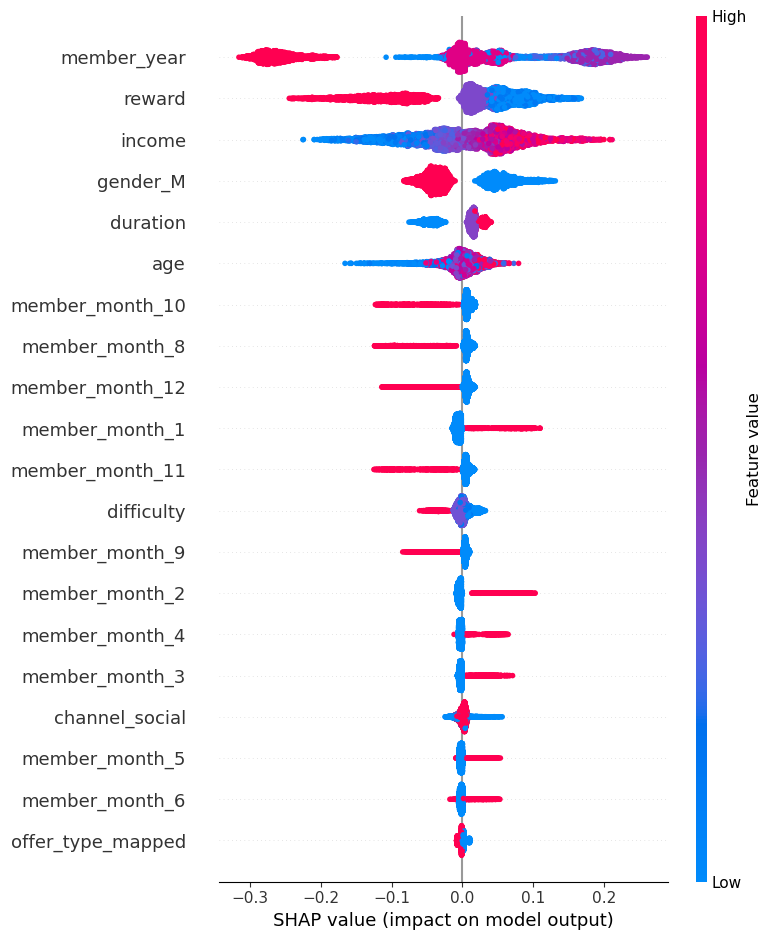

In [153]:
test_data.drop(test_data.columns[0], axis=1, inplace=True)

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(test_data)

# Plotting the SHAP summary
shap.summary_plot(shap_values, test_data)